In [ ]:
# Clone the BCCD dataset from GitHub
!git clone https://github.com/Shenggan/BCCD_Dataset.git


fatal: destination path 'BCCD_Dataset' already exists and is not an empty directory.


In [ ]:
import os

print(os.listdir(os.getcwd()))

['.config', 'cropped_cells_cnn', 'BCCD_Dataset', 'sample_data']


In [ ]:
os.listdir('BCCD_Dataset')

['export.py',
 'plot.py',
 'README.md',
 'BCCD',
 'scripts',
 'example.jpg',
 'LICENSE',
 '.gitignore',
 '.git',
 'test.csv',
 'dataset']

Image Preprocessing

In [ ]:
import os

# Set path to image folder
image_folder = "BCCD_Dataset/BCCD/JPEGImages"

# List a few image filenames
image_files = os.listdir(image_folder)
print("Total images:", len(image_files))
print("First 5 image files:", image_files[:5])


Total images: 364
First 5 image files: ['BloodImage_00075.jpg', 'BloodImage_00252.jpg', 'BloodImage_00405.jpg', 'BloodImage_00345.jpg', 'BloodImage_00400.jpg']


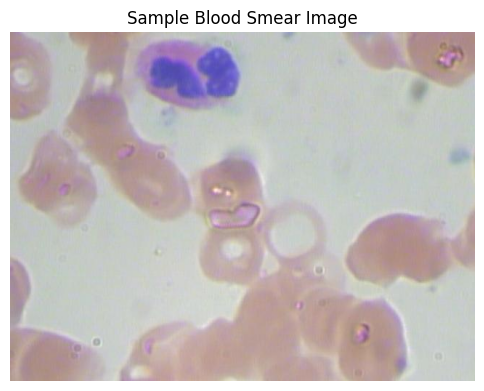

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Pick one image to load
sample_image_path = os.path.join(image_folder, image_files[0])

# Read image using OpenCV
img = cv2.imread(sample_image_path)

# Convert BGR (OpenCV default) to RGB (for correct colors)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show image using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Sample Blood Smear Image")
plt.show()


Loading Texture + XML Annotated Images

Total images found: 364


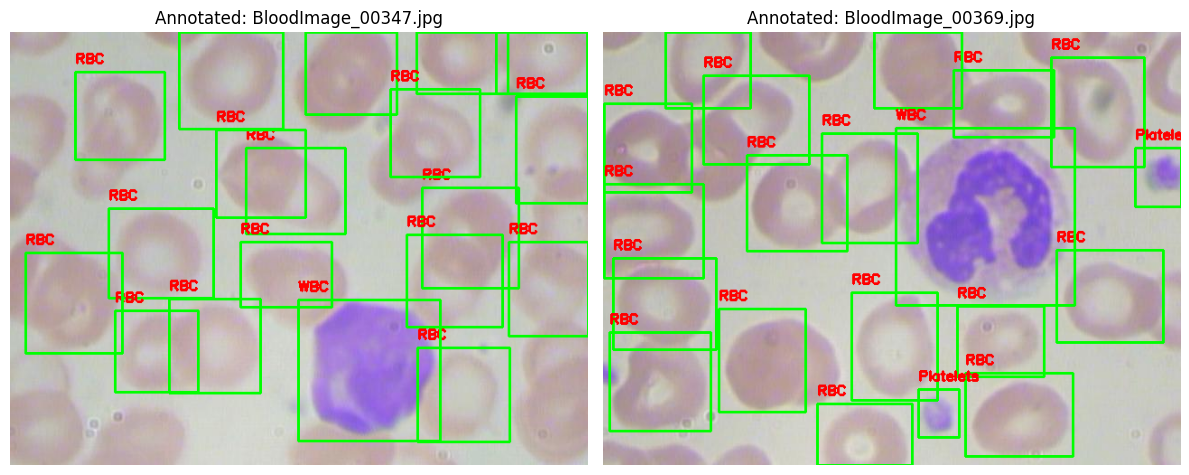

In [ ]:
import os
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import random

image_folder = "BCCD_Dataset/BCCD/JPEGImages"
annotation_folder = "BCCD_Dataset/BCCD/Annotations"


def load_annotation(xml_file):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    boxes = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        boxes.append({'label': label, 'bbox': (xmin, ymin, xmax, ymax)})
    return boxes

def draw_boxes_on_image(image_path, annotation_path):

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    boxes = load_annotation(annotation_path)

    for obj in boxes:
        xmin, ymin, xmax, ymax = obj['bbox']
        label = obj['label']

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        cv2.putText(img, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (255, 0, 0), 2)

    return img

image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
print("Total images found:", len(image_files))

selected_files = random.sample(image_files, 2)


plt.figure(figsize=(12, 6))

for i, file_name in enumerate(selected_files):

    image_path = os.path.join(image_folder, file_name)

    annotation_path = os.path.join(annotation_folder, file_name.replace('.jpg', '.xml'))


    annotated_img = draw_boxes_on_image(image_path, annotation_path)


    plt.subplot(1, 2, i + 1)
    plt.imshow(annotated_img)
    plt.axis('off')
    plt.title(f"Annotated: {file_name}")

plt.tight_layout()
plt.show()


Watershed Segmentation

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def watershed_segmentation(img):
    """
    Performs classical Watershed segmentation on a preprocessed image.

    Parameters:
      img (numpy.array): Preprocessed color image (RGB)

    Returns:
      segmented_img (numpy.array): The image with watershed boundaries drawn (red boundaries)
      markers (numpy.array): The marker image after watershed, with segmentation labels.
    """
    # Convert the image to grayscale - simplifies intensity computation.
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian Blur to reduce noise and smooth out the image.
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use Otsu's thresholding to create a binary image.
    # THRESH_BINARY_INV is used because cells (foreground) typically appear darker than the background.
    ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Remove small noise and disconnect touching objects with morphological opening.
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Dilate the opened image to get sure background areas.
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Apply the distance transform to get the distance from every pixel to the nearest zero pixel.
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

    # Threshold the distance transformed image to get sure foreground areas (centers of cells)
    ret2, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    # Identify unknown regions as the difference between sure background and sure foreground.
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Label the sure foreground regions. This provides markers for each segmented object.
    ret3, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0 but 1.
    markers = markers + 1

    # Mark the unknown region (overlap of background and foreground) as 0.
    markers[unknown == 255] = 0

    # Apply the watershed algorithm on the original color image.
    # After watershed, boundaries are marked with -1 in the marker image.
    markers = cv2.watershed(img, markers)

    # Mark boundaries in red on the original image.
    segmented_img = img.copy()
    segmented_img[markers == -1] = [255, 0, 0]  # Red boundary

    return segmented_img, markers

# Visualization function to quickly inspect the segmentation result.
def show_segmentation(original_img, segmented_img, title='Watershed Segmentation'):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(segmented_img)
    plt.title(title)
    plt.axis('off')
    plt.show()


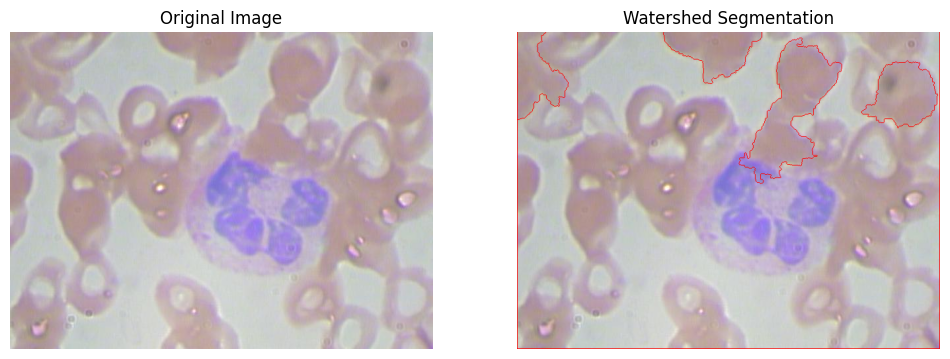

In [ ]:
# Example: Load and apply watershed segmentation on one image
# (Ensure your image is preprocessed; you can also run the preprocessing pipeline before this if needed)
sample_img_path = "BCCD_Dataset/BCCD/JPEGImages/BloodImage_00000.jpg"
# Use our previously defined load_image (from preprocessing) if available
img = cv2.imread(sample_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Apply watershed segmentation
segmented_img, markers = watershed_segmentation(img)

# Visualize the result
show_segmentation(img, segmented_img)


In [ ]:
!pip install scikit-image --quiet

In [ ]:
!pip uninstall -y numpy scikit-image
!pip install numpy==1.23.5 scikit-image==0.19.3


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scikit-image 0.25.2
Uninstalling scikit-image-0.25.2:
  Successfully uninstalled scikit-image-0.25.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 49.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 86.6 MB/s eta 0:00:00
  Created wheel for scikit-image: filename=scikit_image-0.19.3-cp311-cp311-linux_x86_64.whl size=33913392 sha256=1e2a45735caad958c42b745d79e430be654a8d657924a5c74a89a4cd48344b8c
  Stored in directory: /root/.cache/pip/wheels/7b/12/cd/f311cabf9e8708d1e29e9951ee0839fb89b69e1acc60c94927
Successfully built scikit-image
ERROR: pip's dependency resolver does not currently take into account al

In [ ]:
import cv2
import numpy as np
from skimage.measure import regionprops, label
import pandas as pd


Extracting Morphological Features

In [ ]:
def extract_features(img, markers):
    """
    Extracts morphological and color features from segmented WBCs using the marker image.

    Parameters:
        img (numpy.array): Original image (RGB)
        markers (numpy.array): Watershed output with segment labels

    Returns:
        features_df (pd.DataFrame): Dataframe of extracted features for each cell
    """
    features = []

    # We skip marker = 1 (background), and marker = -1 (boundaries)
    for region_label in np.unique(markers):
        if region_label <= 1:
            continue

        # Create a mask for the current region
        mask = np.zeros(markers.shape, dtype=np.uint8)
        mask[markers == region_label] = 255

        # Get contours to calculate area, perimeter, etc.
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue

        contour = contours[0]
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)

        # Bounding box to compute aspect ratio
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h if h != 0 else 0

        # Circularity: 4π * Area / Perimeter²
        circularity = 4 * np.pi * area / (perimeter**2) if perimeter != 0 else 0

        # Masked region for color statistics
        cell_pixels = img[mask == 255]
        mean_color = np.mean(cell_pixels, axis=0)  # R, G, B
        std_color = np.std(cell_pixels, axis=0)

        # Store features
        features.append({
            'Area': area,
            'Perimeter': perimeter,
            'AspectRatio': aspect_ratio,
            'Circularity': circularity,
            'Mean_R': mean_color[0],
            'Mean_G': mean_color[1],
            'Mean_B': mean_color[2],
            'Std_R': std_color[0],
            'Std_G': std_color[1],
            'Std_B': std_color[2]
        })

    # Convert list of dictionaries to DataFrame
    features_df = pd.DataFrame(features)
    return features_df


In [ ]:
# Load the same image
img = cv2.imread("BCCD_Dataset/BCCD/JPEGImages/BloodImage_00000.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Segment it again (or reuse the segmentation result)
segmented_img, markers = watershed_segmentation(img)

# Extract features
features_df = extract_features(img, markers)

# Show first few extracted features
print(features_df.head())


      Area   Perimeter  AspectRatio  Circularity      Mean_R      Mean_G  \
0   5670.0  452.391916     0.575758     0.348147  173.733742  152.861083   
1   6365.0  435.078207     1.897436     0.422546  174.411003  149.411917   
2  13560.5  864.305689     0.707763     0.228113  176.685669  150.171740   
3   7168.5  430.859951     1.128713     0.485250  177.810120  154.622144   

       Mean_B     Std_R     Std_G      Std_B  
0  153.133640  4.564552  7.630810   8.225686  
1  149.802499  4.644059  9.877531  10.150498  
2  162.203834  7.777186  9.074201  17.216824  
3  156.167982  8.336168  8.567979  11.728240  


In [ ]:
import cv2
import numpy as np
import os
import xml.etree.ElementTree as ET
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
import pandas as pd

# ---- Feature Extraction Functions ---- #
def extract_morphological_features(contour):
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter != 0 else 0
    return area, perimeter, circularity

def extract_color_features(img, mask):
    mean_val = cv2.mean(img, mask=mask)[:3]  # mean RGB
    return mean_val

def extract_texture_features(gray_img):
    glcm = graycomatrix(gray_img, [1], [0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]l
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    return contrast, homogeneity

# ---- Parse XML Annotations ---- #
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    for obj in root.findall("object"):
        label = obj.find("name").text
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        boxes.append({"label": label, "bbox": (xmin, ymin, xmax, ymax)})
    return boxes

# ---- Extract Features from Annotated Cells ---- #
def extract_features_from_image(image_path, annotation_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    boxes = parse_annotation(annotation_path)

    features = []

    for box in boxes:
        xmin, ymin, xmax, ymax = box['bbox']
        label = box['label']

        roi = img[ymin:ymax, xmin:xmax]
        gray_roi = gray[ymin:ymax, xmin:xmax]

        # Binary mask for color features
        mask = np.ones(gray_roi.shape, dtype=np.uint8) * 255
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            area, perimeter, circularity = extract_morphological_features(contours[0])
            mean_r, mean_g, mean_b = extract_color_features(roi, mask)
            contrast, homogeneity = extract_texture_features(gray_roi)

            features.append({
                'Label': label,
                'Area': area,
                'Perimeter': perimeter,
                'Circularity': circularity,
                'Mean_R': mean_r,
                'Mean_G': mean_g,
                'Mean_B': mean_b,
                'Contrast': contrast,
                'Homogeneity': homogeneity
            })

    return features

# ---- Run on 2 Sample Images ---- #
image_dir = 'BCCD_Dataset/BCCD/JPEGImages'
annotation_dir = 'BCCD_Dataset/BCCD/Annotations'
image_files = sorted(os.listdir(image_dir))[:2]  # first 2 images

all_features = []
for file in image_files:
    if file.endswith('.jpg'):
        xml_name = file.replace('.jpg', '.xml')
        features = extract_features_from_image(
            os.path.join(image_dir, file),
            os.path.join(annotation_dir, xml_name)
        )
        all_features.extend(features)

# ---- Convert to DataFrame ---- #
df = pd.DataFrame(all_features)
print(df.head())


  Label     Area  Perimeter  Circularity      Mean_R      Mean_G      Mean_B  \
0   WBC  45540.0      856.0     0.781008  179.993735  163.922230  200.864474   
1   RBC  10290.0      406.0     0.784464  194.654183  187.778826  192.074138   
2   RBC  10290.0      406.0     0.784464  184.612540  170.316276  170.396131   
3   RBC  10290.0      406.0     0.784464  203.471603  191.363065  192.618258   
4   RBC   8372.0      366.0     0.785375  194.761805  179.222651  180.636746   

   Contrast  Homogeneity  
0  5.126131     0.482504  
1  6.591631     0.487254  
2  6.633189     0.525307  
3  5.521212     0.527838  
4  6.404939     0.441817  


In [ ]:
import os
import cv2
import xml.etree.ElementTree as ET

# Paths
image_dir = 'BCCD_Dataset/BCCD/JPEGImages'
annotation_dir = 'BCCD_Dataset/BCCD/Annotations'
output_dir = 'cropped_cells_cnn'

# Create class-wise folders
os.makedirs(output_dir, exist_ok=True)

# List of XML files (you can limit to a few for quick testing)
xml_files = sorted(os.listdir(annotation_dir))[:30]  # change to more later

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    for obj in root.findall("object"):
        label = obj.find("name").text
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        boxes.append({'label': label, 'bbox': (xmin, ymin, xmax, ymax)})
    return boxes

# Crop and save
count = 0
for xml_file in xml_files:
    image_file = xml_file.replace('.xml', '.jpg')
    image_path = os.path.join(image_dir, image_file)
    annotation_path = os.path.join(annotation_dir, xml_file)

    img = cv2.imread(image_path)
    boxes = parse_annotation(annotation_path)

    for obj in boxes:
        label = obj['label']
        xmin, ymin, xmax, ymax = obj['bbox']
        cell_crop = img[ymin:ymax, xmin:xmax]

        # Create class folder
        class_folder = os.path.join(output_dir, label)
        os.makedirs(class_folder, exist_ok=True)

        # Save cropped cell
        save_path = os.path.join(class_folder, f'{label}_{count}.jpg')
        cv2.imwrite(save_path, cell_crop)
        count += 1

print("✅ Cropped cells saved for CNN training.")


✅ Cropped cells saved for CNN training.


Dataset Loader

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define image transformations (resize, normalize, augment)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Load dataset
data_dir = 'cropped_cells_cnn'
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Train/val split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Classes: {dataset.classes}")
print(f"Total images: {len(dataset)} | Train: {len(train_dataset)}, Val: {len(val_dataset)}")


Classes: ['Platelets', 'RBC', 'WBC']
Total images: 563 | Train: 450, Val: 113


In [ ]:
import torchvision.models as models
import torch.nn as nn

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Freeze all pretrained layers (optional, or allow fine-tuning)
for param in model.parameters():
    param.requires_grad = False

# Replace the final FC layer to match 4 output classes
num_classes = 4
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, num_classes)
)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 154MB/s]


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        acc = 100 * correct / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss:.4f} | Accuracy: {acc:.2f}%")

        # Validation step
        model.eval()
        with torch.no_grad():
            correct = 0
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                correct += (outputs.argmax(1) == labels).sum().item()
            val_acc = 100 * correct / len(val_loader.dataset)
            print(f"Validation Accuracy: {val_acc:.2f}%\n")


In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch [1/10] Loss: 13.6872 | Accuracy: 84.89%
Validation Accuracy: 90.27%

Epoch [2/10] Loss: 4.5961 | Accuracy: 93.56%
Validation Accuracy: 99.12%

Epoch [3/10] Loss: 1.6792 | Accuracy: 99.11%
Validation Accuracy: 100.00%

Epoch [4/10] Loss: 1.6668 | Accuracy: 99.11%
Validation Accuracy: 100.00%

Epoch [5/10] Loss: 2.3699 | Accuracy: 98.22%
Validation Accuracy: 100.00%

Epoch [6/10] Loss: 0.5021 | Accuracy: 99.78%
Validation Accuracy: 100.00%

Epoch [7/10] Loss: 1.3986 | Accuracy: 99.56%
Validation Accuracy: 100.00%

Epoch [8/10] Loss: 1.1660 | Accuracy: 98.44%
Validation Accuracy: 100.00%

Epoch [9/10] Loss: 1.2681 | Accuracy: 99.56%
Validation Accuracy: 100.00%

Epoch [10/10] Loss: 0.9237 | Accuracy: 98.89%
Validation Accuracy: 100.00%



In [ ]:
!pip install torchcam --quiet


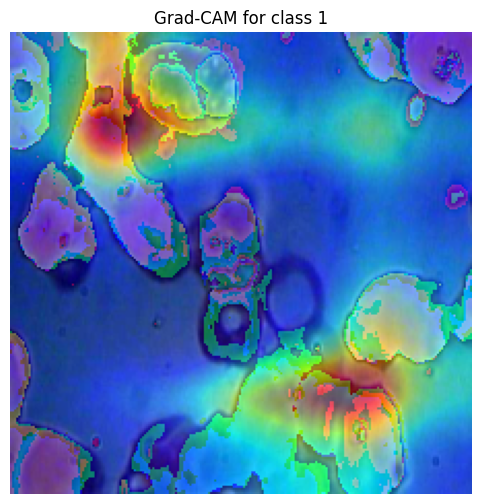

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms import Normalize, Resize, Compose, ToTensor

# Transforms to match training pre-processing
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406],
              [0.229, 0.224, 0.225])
])

# Use SmoothGradCAM++ on the final conv layer
cam_extractor = SmoothGradCAMpp(model, target_layer='layer4')
from PIL import Image
import torch
img_path = 'BCCD/JPEGImages/BloodImage_00014.jpg'
img_path = os.path.join(image_dir, image_files[0])  # or [1], [2], etc.

img = Image.open(img_path).convert("RGB")


input_tensor = transform(img).unsqueeze(0).to(device)
input_tensor.requires_grad_()


# Forward pass to get prediction
model.eval()
out = model(input_tensor)
pred_class = out.argmax(dim=1).item()

# Extract CAM
activation_map = cam_extractor(pred_class, out)

# Convert to PIL and overlay
result = overlay_mask(
    to_pil_image(input_tensor.squeeze().cpu()),
    to_pil_image(activation_map[0].squeeze(0).cpu(), mode='F'),
    alpha=0.5
)

# Plot
plt.figure(figsize=(6, 6))
plt.title(f"Grad-CAM for class {pred_class}")
plt.imshow(result)
plt.axis('off')
plt.show()


In [ ]:
class_names = ['Neutrophil', 'Lymphocyte', 'Monocyte', 'Eosinophil']
print(f"Predicted class: {class_names[pred_class]}")




Predicted class: Lymphocyte


In [ ]:
from PIL import Image
import os
from torchvision import transforms

image_dir = 'BCCD_Dataset/BCCD/JPEGImages'
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(".jpg")]


In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms
from collections import Counter

# Define the class names
class_names = ['Neutrophil', 'Lymphocyte', 'Monocyte', 'Eosinophil']

# Define transformation to match the training preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Initialize counter for differential count
counts = Counter()

# Load your model (ensure it is correctly loaded)
model.eval()

# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Disable hooks during inference
def forward_hook(module, input, output):
    return output

# Remove any hooks registered to the model
for module in model.modules():
    module._forward_hooks.clear()  # Clear any registered hooks

# Directory containing images
image_dir = 'BCCD_Dataset/BCCD/JPEGImages'

# Get list of all image paths (only .jpg files)
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(".jpg")]

# Loop through the image paths
for img_path in image_paths:
    # Load and preprocess the image
    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)  # No requires_grad here

    # Make prediction (forward pass)
    with torch.no_grad():  # Ensure that gradients are not tracked
        output = model(input_tensor)

    # Get the predicted class
    pred_class = output.argmax(dim=1).item()

    # Update the count for the predicted class
    counts[class_names[pred_class]] += 1

# Print the final differential count
print("Blood Differential Count:")
for class_name, count in counts.items():
    print(f"{class_name}: {count}")


Blood Differential Count:
Lymphocyte: 364


In [ ]:
import os
from collections import Counter

# Define the image directory
image_dir = 'BCCD_Dataset/BCCD/JPEGImages'  # Path to your dataset
image_files = [fname for fname in os.listdir(image_dir) if fname.endswith(".jpg")]

# Define the class names and labels for your dataset
# Here assuming your image filenames include the class information, adjust accordingly
class_names = ['Neutrophil', 'Lymphocyte', 'Monocyte', 'Eosinophil']

# Initialize counter for class frequency
class_counts = {class_name: 0 for class_name in class_names}

# Loop through the image files to count occurrences of each class
for image_file in image_files:
    # Assuming image file names include the class name, e.g. "Lymphocyte_001.jpg"
    # Modify based on your dataset naming conventions or annotation file
    for class_name in class_names:
        if class_name in image_file:
            class_counts[class_name] += 1
            break  # Exit the loop once the class is found in the filename

# Print the class distribution
print("Class distribution:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")


Class distribution:
Neutrophil: 0 images
Lymphocyte: 0 images
Monocyte: 0 images
Eosinophil: 0 images


Class distribution in the dataset:
RBC: 4155
Platelets: 361
WBC: 372


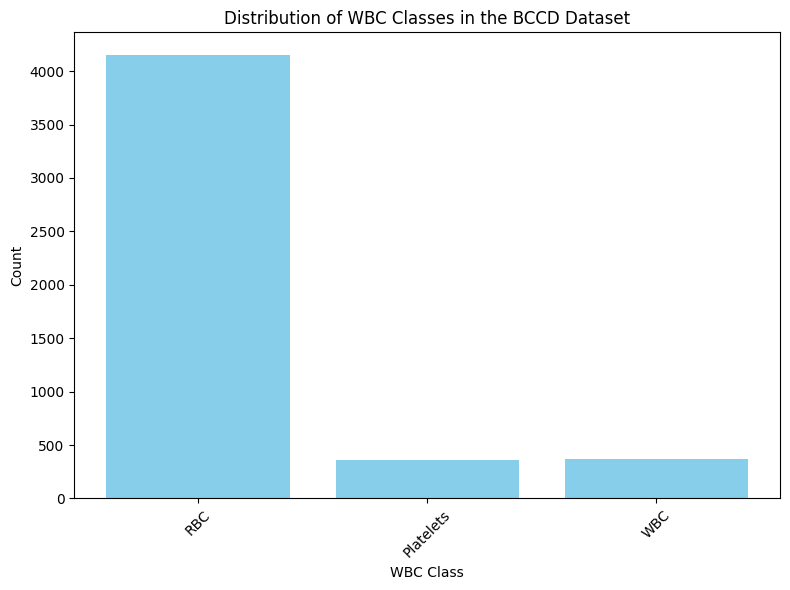

In [ ]:
import os
import xml.etree.ElementTree as ET
from collections import Counter
import matplotlib.pyplot as plt

# Path to the BCCD dataset annotation folder
annotation_folder = "BCCD_Dataset/BCCD/Annotations"

# Function to load annotations from XML files
def load_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    labels = []
    for obj in root.findall('object'):
        label = obj.find('name').text  # Extract the label (WBC class)
        labels.append(label)
    return labels

# Initialize a Counter to count the occurrences of each WBC class
wbc_counts = Counter()

# Loop through the XML files in the annotation folder
xml_files = [f for f in os.listdir(annotation_folder) if f.endswith('.xml')]
for xml_file in xml_files:
    annotation_path = os.path.join(annotation_folder, xml_file)
    labels = load_annotation(annotation_path)
    wbc_counts.update(labels)  # Update the counts with the labels for this image

# Print the counts of each WBC class
print("Class distribution in the dataset:")
for label, count in wbc_counts.items():
    print(f"{label}: {count}")

# Visualize the class distribution
plt.figure(figsize=(8, 6))
plt.bar(wbc_counts.keys(), wbc_counts.values(), color='skyblue')
plt.xlabel('WBC Class')
plt.ylabel('Count')
plt.title('Distribution of WBC Classes in the BCCD Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
